In [1]:

# Running PYTHON 3.12.0 

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch 

#from sklearn.model_selection  import train_test_split

import calibrationUtilities as cut
import utilities as ut
import gradientHypUtilities_v4 as gt

#import tensorflow as tf

# 1) Generate some input data, and put it into a regressor matrix  

In [2]:
q = 199 # NFIR lag length

n = 30000
t = np.linspace(1, n, n)

ut_sin = (1 + 2*t/n) * np.sin(t/200) + 0.1*np.cos(t/25) + 0.01*np.random.randn(n)

X = cut.createInputMatrix(ut_sin, q, n-q)  # The regressor matrix - each row explains one output 

# 2) Define the kernel of the NFIR true system

This is a linear combination of 17 kernel sections of the kernel $K_x$.

This code implements a multiplicative kernel: 
$$
K_x(x_1,x_2) = \rho_L (x_1^T \Lambda_L x_2) \; \exp \Big(- (x_1 - x_2)^T \Lambda_{NL} (x_1 - x_2) \cdot l_{NL} \Big)
$$



In [3]:

# TRUE PARAMETERS: 

alphaL = 0.7   # Linear kernel stability/smoothenss parameter
alphaNL = 0.7   # Nonlinear kernel stability/smoothness parameter 
lengthNL = 0.05 # Length scale parameter of the squared exponential in Kx

rhoL =  5  # Coefficient to the linear kernel
rhoNL = 1       # Coefficient to the nonlinear kernel

rhoT = 1        # Coefficient to the calibration parameter kernel
alphaT = 0.1615  # K_t kernel length scale parameter

sigma2y = 0.00005  # variance of additive noise on the output
d = 0.6

hpams = {"alphaL": alphaL, "alphaNL": alphaNL, "rhoL": rhoL, "lengthNL": lengthNL, "rhoNL": rhoNL, "rhoT": rhoT, "alphaT": alphaT, "sigma2": sigma2y, "d": d}

gpmodel = cut.GPFIR(hpams, q, nkernel="TC", lkernel="TC")

# 3) Make sample signals to define the true system 

17 samples yields 17 kernels that make the true system. 
$$
f(\cdot) = \sum_{i=1}^{17} w_i K(\cdot, x_i)
$$



In [4]:
np.random.seed(14) # for reproducibility 

nidx = 15000
idx = np.random.randint(nidx-q-1-3000, nidx-q-1, 17) # sample 17 signals to define the true system

xSYS = X[idx, :] + 0.8          

wsys = 1e-3 * np.ones_like(idx)   # the weights 

# 4) Simulate outputs with the true system

And apply additive noise aswell. 

In [5]:
response_train, _ = gpmodel.getKxms(X.T, xSYS.T) # representers from X_test, based on X_train - to predict X_test from X_train

y = np.dot(response_train, wsys)

y_noise = y + np.sqrt(sigma2y)*np.random.randn(X.shape[0])

snr = np.var(y) / (np.var(y_noise) - np.var(y))
print("SNR:", snr)
print(np.var(y))

SNR: 2468.2733097867235
0.11601854471912927


# 5) Split the data into test and training sets

In [6]:
ntest  = 3000
X_test = X[nidx: nidx + ntest, :]
y_test = y_noise[nidx: nidx + ntest]


ntrain = 3000
X_train = X[nidx -ntrain: nidx, :]
y_train = y_noise[nidx -ntrain: nidx]

# Normalize X_train and xss_matrix
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0) + 1e-12  # prevent division by zero

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean = np.mean(y_train)
y_std = np.std(y_train) + 1e-12
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

print(X_train.shape)

(3000, 199)


# 6) Compute the true steady states of the system 

In [7]:

# Steady state of this system: 

alist = np.linspace(-4, 4, 200)
ss_rep, cov = gpmodel.getKsteadyState(alist, xSYS)   # returns the representers and the covariance of the steady states in alist 

ss_sys = ss_rep @ wsys

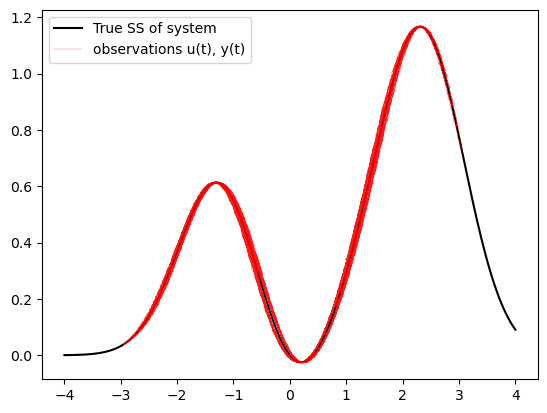

In [8]:

plt.figure()

plt.plot(alist, ss_sys, 'k-', label="True SS of system ")

plt.plot(X[:, 0], y, 'r', linewidth=0.2, alpha=0.9, label="observations u(t), y(t)")

plt.legend()

plt.show()

# 7) Generate some simulation data, with an additive calibration parameter

Using the steady state of the true system, above, we generate synthetic simulations. 

To these simulations we can add an error that we model with the calibration parameter. 

In this case we make a simple choice; the calibration parameter is simply a constant added to the true steady state, i.e.
$$
y_s = f(x_s) + \theta
$$

where $x_s$ is a constant vector. 

In [9]:

u = alist

thetas = np.array([-0.5, 0, 0.5, 1])
theta = np.linspace(1 , 1, num=3000)

iss = 19*4
xss_list = np.linspace(-0.9, -0.8, thetas.shape[0])

yss, xss_matrix, KssKt, Kms = cut.prepDs(thetas, xss_list, X_train, xSYS, wsys, q, gpmodel)
xss_matrix = (xss_matrix - X_mean) / X_std  
yss = (yss - y_mean) / y_std

In [10]:
print(ss_sys[iss], alist[iss], " is the (x, y) location of the true system at these simulations. ") 

0.5248637928065354 -0.9447236180904524  is the (x, y) location of the true system at these simulations. 


# Tuning of hyperparameters:

### Some matrix tricks: 



\begin{align}
    K = \begin{pmatrix}
        K_x(X_m, X_m) & K_x(X_m, X_s) \odot K_\theta (\tilde \theta, \Theta_s) \\
        K_x(X_s, X_m) \odot  K_\theta(\Theta_s, \tilde \theta) & K_x(X_s, X_s) \odot K_\theta(\Theta_s, \Theta_s)
    \end{pmatrix}  
\end{align}

\begin{align}
    E = \begin{pmatrix}
        K_\epsilon & 0 \\
        0 & K_b(X_s, X_s) 
    \end{pmatrix}  
\end{align}


Cholesky decompositions: 

$$
\begin{align}
    L_A L_A^T &= K_x(X_m, X_m) + K_\epsilon \\
    L_K L_K^T &= K(\theta) \\
    L_K &= \begin{pmatrix}
        L_A & 0 \\ 
         K_x(X_s, X_m) \odot  K_\theta(\Theta_s,  \theta) (L_A^T)^{-1} & L_S
    \end{pmatrix}
\end{align}
$$

$$
\begin{align}
    L_S L_S^T &= S \\
    S&= K_x(X_s, X_s) K_\theta(\Theta_s, \Theta_s) + K_b(X_s, X_s) \\& - \Big[(L_A)^{-1} K_x(X_m, X_s) \odot  K_\theta(\theta, \Theta_s)\Big]^T(L_A)^{-1} K_x(X_m, X_s) \odot  K_\theta(\theta, \Theta_s)
\end{align}
$$

In [11]:
t1mt2 = np.subtract.outer(thetas, thetas)

Kt = gpmodel.Kt(t1mt2)
print(Kt.shape)

t1mts2 = np.subtract.outer(theta, thetas)
ts1mt2 = np.subtract.outer(thetas, theta)

Kts = gpmodel.Kt(t1mts2)
print(Kts.shape)

Kss, Keee,xs1Bxs2 = gpmodel.getKm(xss_matrix)  # TODO: Make the GP return Kx, and Ke separately 

(4, 4)
(3000, 4)


In [12]:
Kms, xm1Bxs2 = gpmodel.getKxms(X_train.T, xss_matrix.T)
print(Kms.shape)

(3000, 4)


In [13]:
Kx, Ke, xBx = gpmodel.getKm(X_train) # Takes 2-3 minutes 

In [14]:
Ks = gpmodel.getKs(xss_matrix, thetas)
Kb, x1x2 = gpmodel.Kd(xss_matrix,xss_matrix)

In [15]:
E_11 = Ke
E_12 = np.zeros((Ke.shape[0], Kb.shape[1]))
E_21 = np.zeros((Kb.shape[0], Ke.shape[1]))
E_22 = Kb
e = np.block([[E_11, E_12], [E_21, E_22]])
np.linalg.cond(e)
#print(sigma2y)

68247.01683525108

$$
K_x(x_1, x_2) = x_1^T A x_2 \cdot \exp (- (x_1 - x_2)^T B (x_1 -x_2))
$$

$$
K_\theta(t_1, t_2) = \exp(- (t_1 - t_2)^2 \rho_\theta)
$$


$$
K_\delta (x_1, x_2) = \exp( - (x_1 - x_2)^T D (x_1 - x_2))
$$

# Computing the K Matrix

In [16]:
Ksm, xs1Bxm2 = gpmodel.getKxms(xss_matrix.T, X_train.T)
ts1mt2 = np.subtract.outer(thetas, theta)
Kst = gpmodel.Kt(ts1mt2)

In [17]:
# The requisite Paramaters
y_train = np.reshape(y_train,(y_train.size,1))
yss = np.reshape(yss,(yss.size,1))
y = np.vstack((y_train,yss))
n = y.shape[0]

# Initialization of Hyperparameters

In [18]:
# Hyperparameter Iniitializations for the Alternating Minimization Computation

alphaL_in = 0.80  # Linear kernel stability/smoothenss parameter
alphaNL_in = 0.80    # Nonlinear kernel stability/smoothness parameter 
lengthNL_in = 0.04 # Length scale parameter of the squared exponential in Kx

rhoL_in =  4   # Coefficient to the linear kernel
rhoNL_in = 1      # Coefficient to the nonlinear kernel

rhoT_in = 1        # Coefficient to the calibration parameter kernel
alphaT_in = 0.12  # K_t kernel length scale parameter

sigma2y_in = 0.00004  # variance of additive noise on the output
d_in = 0.5

hpams_in = {"alphaL": alphaL_in, "alphaNL": alphaNL_in, "rhoL": rhoL_in, "lengthNL": lengthNL_in, "rhoNL": rhoNL_in, "rhoT": rhoT_in, "alphaT": alphaT_in, "sigma2": sigma2y_in, "d": d_in}

# Computing the K matrix from the Initialized Hyperparameters

In [19]:
# Compute the matrix K
def compute_ke(hpams_in):
    gpmodel_in = cut.GPFIR(hpams_in, q, nkernel="TC", lkernel="TC")
    t1mt2 = np.subtract.outer(thetas, thetas)
    Kt = gpmodel_in.Kt(t1mt2)
    t1mts2 = np.subtract.outer(theta, thetas)
    Kts = gpmodel_in.Kt(t1mts2)
    Kss, Keee, xs1Bxs2 = gpmodel_in.getKm(xss_matrix)
    Kms, xm1Bxs2 = gpmodel_in.getKxms(X_train.T, xss_matrix.T)
    Kx, Ke, xBx = gpmodel_in.getKm(X_train)
    Ks = gpmodel.getKs(xss_matrix, thetas)
    Kb, x1x2 = gpmodel_in.Kd(xss_matrix, xss_matrix)
    Ksm, xs1Bxm2= gpmodel_in.getKxms(xss_matrix.T, X_train.T)
    ts1mt2 = np.subtract.outer(thetas, theta)
    Kst = gpmodel_in.Kt(ts1mt2)
    K_11 = Kx
    K_12 = Kms * Kts
    K_21 = Ksm * Kst
    K_22 = Ks
    k = np.block([[K_11, K_12], [K_21, K_22]])
    E_11 = Ke
    E_12 = np.zeros((Ke.shape[0], Kb.shape[1]))
    E_21 = np.zeros((Kb.shape[0], Ke.shape[1]))
    E_22 = Kb
    e = np.block([[E_11, E_12], [E_21, E_22]])
    print("Condition number:", np.linalg.cond(k+e))
    return k, e

## Diagnostic Section

In [20]:
def diagnose_and_patch(hpams):
    K, E = compute_ke(hpams)    # ensure compute_ke uses normalized data
    K = 0.5*(K+K.T)
    n = K.shape[0]
    print("cond(K) before:", np.linalg.cond(K))
    w = np.linalg.eigvalsh(K)
    print("K eigvals min,max:", w[0], w[-1])
    # if too ill-conditioned, test small K-jitter
    for j in [1e-12,1e-10,1e-8,1e-6,1e-4,1e-2]:
        condj = np.linalg.cond(K + j*np.eye(n))
        print("jitter", j, "cond(K+jI)", condj)
        if condj < 1e10:
            print("Use jitter", j, "on K")
            return K, E, j
    print("Try increasing d or sigma2; current hpams:", hpams)
    return K, E, None

In [21]:
diagnose_and_patch(hpams_in)

Condition number: 5947261679.798888
cond(K) before: 1.0453136239376582e+17
K eigvals min,max: -66.86426016320102 237890.4011258639
jitter 1e-12 cond(K+jI) 6.657800113947499e+16
jitter 1e-10 cond(K+jI) 2599753534691785.0
jitter 1e-08 cond(K+jI) 23824835792019.906
jitter 1e-06 cond(K+jI) 237895206916.07144
jitter 0.0001 cond(K+jI) 2378904317.305314
Use jitter 0.0001 on K


(array([[275.25932907, 275.15991503, 274.94401409, ...,  44.23692237,
          43.30067725,  39.73218142],
        [275.15991503, 275.06189371, 274.84666239, ...,  44.27025569,
          43.33502102,  39.76526897],
        [274.94401409, 274.84666239, 274.63375461, ...,  44.34251424,
          43.40949666,  39.83704454],
        ...,
        [ 44.23692237,  44.27025569,  44.34251424, ...,  27.59545558,
          25.27820139,  21.30904119],
        [ 43.30067725,  43.33502102,  43.40949666, ...,  25.27820139,
          25.10290952,  22.94093375],
        [ 39.73218142,  39.76526897,  39.83704454, ...,  21.30904119,
          22.94093375,  22.72832406]]),
 array([[4.00000000e-05, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.00000000e-05, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.00000000e-05, ...,
         0.00000000e+00, 0.00000000

# Additional Parameter for Passing

In [22]:
pam = {"xm": X_train.T, "xs": xss_matrix.T, "theta": theta, "thetas": thetas, "y": y, "q": q}

## Hyperparameter Plot for $\alpha_L$

Condition number: 4705473273.875041
Condition number: 4599046648.429133
Condition number: 4481902028.448045
Condition number: 4353402974.775231
Condition number: 4213147246.193494
Condition number: 4061138614.573716
Condition number: 3897993565.9062176
Condition number: 3725262778.980718
Condition number: 3545772735.58555
Condition number: 3364049209.4783545
Condition number: 3186640826.270682
Condition number: 3022156526.5095477
Condition number: 2880502597.5910487
Condition number: 2769457799.63562
Condition number: 2684659609.146532
Condition number: 2604030528.7314687
Condition number: 2505202573.5198064
Condition number: 2371686448.9909363
Condition number: 2178724130.1922736
Condition number: 1891982923.782497


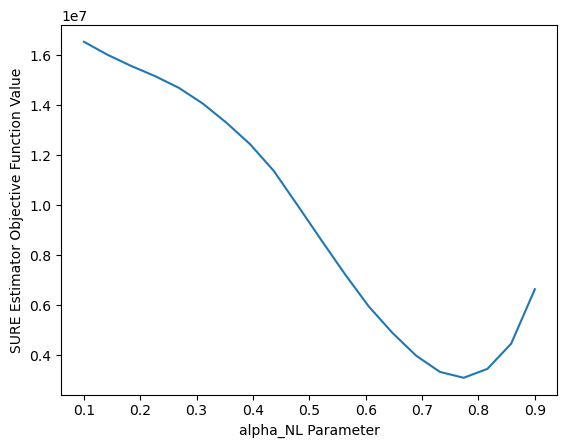

In [23]:
# Initializing alpha_L
anl = np.linspace(0.1, 0.9, 20, endpoint=True)

# Initializing the SURE estimator
# Value array
s = np.zeros(len(anl))

# Loop for Computing the SURE estimator
# Objective function
for j in range(len(anl)):

    # Extracting the alpha_L for the iteration
    anL = anl[j]

    # The hyperparameter dictionary
    hp = {"alphaL": alphaL, "alphaNL": anL, "rhoL": rhoL, "lengthNL": lengthNL, "rhoNL": rhoNL, "rhoT": rhoT, "alphaT": alphaT, "sigma2": sigma2y, "d": d}

    # Compute the K matrix
    k, e = compute_ke(hp)

    # Compute the SURE estimator
    s[j] = gt.sure(y,k,e)

plt.plot(anl, s)
plt.xlabel("alpha_NL Parameter")
plt.ylabel("SURE Estimator Objective Function Value")
plt.show()

## Use Finite Difference to Test Variability

In [24]:
eps = 1e-6

hpams_p = hpams_in.copy()
hpams_m = hpams_in.copy()

hpams_p["alphaNL"] = hpams_in["alphaNL"] + eps
hpams_m["alphaNL"] = hpams_in["alphaNL"] - eps

kp, ep = compute_ke(hpams_p)
km, em = compute_ke(hpams_m)

f1 = gt.sure(y, kp, ep)
f0 = gt.sure(y, km, em)

num_grad = (f1 - f0) / (2 * eps)

# Analytical gradient (index 0 corresponds to alpha_NL)
gr_eta = gt.f_grad_eta(hpams_in, pam)
ana_grad = gr_eta[1]

print("Delta SURE:", f1 - f0)
print("Numerical grad (alphaNL):", num_grad)
print("Analytical grad (alphaNL):", ana_grad)

Condition number: 5947255007.835527
Condition number: 5947272739.679094
Delta SURE: 36.271884680725634
Numerical grad (alphaNL): 18135942.340362817
Analytical grad (alphaNL): -80782793828.63525


# Hyperparameter Tuning

# Alternative Minimization Subroutine for Hyperparameter Tuning

# Hyperparameter Tuning call

In [25]:
def alt_min(hpams_in, pam, n_iter, epsilon):

    step_size = 0.05
    beta = 0.9
    s = np.zeros(n_iter + 1)

    # Computing k
    k, e = compute_ke(hpams_in)

    # Momentum terms Initialization
    v_eta = np.zeros(4)
    v_at = 0
    v_nu = 0
    v_d = 0

    # Clipping Values
    clip_min_eta = np.array([1e-3, 1e-3, 1e-3, 1e-3])
    clip_max_eta = np.array([1, 1, 1e4, 1e-1])
    #clip_min_phi = np.array([1e-3, 1e-3, 1e-3])
    #clip_max_phi = np.array([1, 10, 10])

    # Copying the hyperparamter dictionary
    hp = hpams_in.copy()

    # Getting the numerical array
    x = np.array(list(hpams_in.values()))
    s[0] =  gt.sure(y,k,e)
    x_list = []

    hpams = {"alphaL": x[0], "alphaNL": x[1], "rhoL": x[2], "lengthNL": x[3], "rhoNL": x[4], "rhoT": x[5], "alphaT": x[6], "sigma2": x[7], "d": x[8]}
    
    for j in range(n_iter):

        # Keep the old hyperparameters
        x_old = x.copy()
        x_list.append(x_old)

        ## Adaptive gradient descent for eta
        
        # Computing the gradient for eta
        grad_eta = gt.f_grad_eta(hpams, pam)
        print(grad_eta)

        # Update momentum for adaptive learning rate
        v_eta = beta * v_eta + (1 - beta) * grad_eta ** 2
            
        # Step-size update
        x[0:4] -= (step_size / (np.sqrt(v_eta) + 1e-8)) * grad_eta
        #x[0:4] -= step_size * grad_eta

        # Value clipping for eta
        x[0:4] = np.clip(x[0:4], clip_min_eta, clip_max_eta)

        # Updating the hyperparameter list
        hpams["alphaL"] = x[0]
        hpams["alphaNL"] = x[1]
        hpams["rhoL"] = x[2]
        hpams["lengthNL"] = x[3]

        k, e = compute_ke(hpams)
        
        # Resulting Objective Function Value
        # After the Iteration
        print(f"SURE objective value after first block optimization:{gt.sure(y,k,e)}")

        ## Adaptive gradient descent for alpha_t
        # Computing the gradient for alpha_t
        grad_at = gt.f_grad_at(hpams, pam)

        print(grad_at)

        # Update momentum for adaptive learning rate
        v_at = beta * v_at + (1 - beta) * grad_at ** 2
            
        # Adaptive step-size update
        x[6] -= (step_size / (np.sqrt(v_at) + 1e-8)) * grad_at

        # Value clipping for x[6]
        x[6] = np.clip(x[6], 1e-3, 1)

        # Updating hyperparameter
        hpams["alphaT"] = x[6]

        ## Adaptive gradient descent for sigma2
        
        # Computing the gradient for sigma2
        grad_nu = gt.f_grad_nu(hpams, pam)

        print(grad_nu)

        # Update momentum for adaptive learning rate
        v_nu = beta * v_nu + (1 - beta) * grad_nu ** 2
            
        # Adaptive step-size update
        x[7] -= (step_size / (np.sqrt(v_nu) + 1e-8)) * grad_nu

        # Value clipping for x[7]
        x[7] = np.clip(x[7], 1e-3, 10)

        # Updating hyperparameter
        hpams["sigma2"] = x[7]

        ## Adaptive gradient descent for d
        
        # Computing the gradient for d
        grad_d = gt.f_grad_d(hpams, pam)

        print(grad_d)

        # Update momentum for adaptive learning rate
        v_d = beta * v_d + (1 - beta) * grad_d ** 2
            
        # Adaptive step-size update
        x[8] -= (step_size / (np.sqrt(v_d) + 1e-8)) * grad_d

        # Value clipping for x[8]
        x[8] = np.clip(x[8], 1e-3, 10)

        # Updating hyperparameter
        hpams["d"] = x[8]
        

        print(f"Hyperparameter values for {j+1} th iteration:{x}")

        k, e = compute_ke(hpams)
        
        # Resulting Objective Function Value
        # After the Iteration
        s[j+1] = gt.sure(y,k,e)
        print(f"SURE Objective function value for {j+1} th iteration:{s[j+1]}")
        #print(f"Normed hyperparameter difference:{np.linalg.norm(x - x_old)}")
        
        # Check convergence
        if np.abs(s[j+1] - s[j]) < epsilon: 
            break

    x_matrix = np.vstack(x_list)

    return x_matrix, s

In [26]:
n_iter = 20
epsilon = 0.9
x_matrix, s = alt_min(hpams_in, pam, n_iter, epsilon)
print(s)

Condition number: 5947261679.798888
[-2.51127093e+08 -8.07827938e+10  2.82324861e+06  8.77249650e+10]
Condition number: 146461127126.20157
SURE objective value after first block optimization:8798743.139208073
21513042.920490246
-8541331955.731332
688.2757536861759
Hyperparameter values for 1 th iteration:[9.58113883e-01 9.58113883e-01 3.84188612e+00 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.58153883e-01
 3.41886117e-01]
Condition number: 371144635.7961679
SURE Objective function value for 1 th iteration:34467.76742405456
[ 1.32575828e+05 -3.62403783e+05 -6.63263691e+02 -1.28669962e+07]
Condition number: 324314460.28391284
SURE objective value after first block optimization:27450.330688522245
-183099105.23237088
-57257.71721983157
-135.80422219095698
Hyperparameter values for 2 th iteration:[9.58025896e-01 9.58114631e-01 3.84192527e+00 1.02444571e-03
 1.00000000e+00 1.00000000e+00 1.58140711e-01 1.58155000e-01
 3.74082260e-01]
Condition number: 1442554217.9398134
SU

In [27]:
iter = np.size(x_matrix[:,1])

## Function for Predicting the Output from Hyperparameter

In [28]:
def predict(hpams):

    # Initializing jitter
    jitter = 1e-2
    
    # Compute K and E
    k, e = compute_ke(hpams)

    # Hat matrix
    #h = k @ np.linalg.inv(k+e+(jitter*np.eye(k.shape[0])))
    h = np.linalg.solve(k + e + jitter*np.eye(k.shape[0]), k).T

    #print("H min/max:", h.min(), h.max())
    #print("Condition number:", np.linalg.cond(k + e))
    #eigvals = np.linalg.eigvals(k + e)
    #print("Eigenvalues min/max:", eigvals.min(), eigvals.max())

    # Predicted output
    y_hat = h @ y

    return y_hat

## Predicting Output Values

In [29]:
y_hat = np.zeros((iter, np.size(y)))
for i in range(iter):

    x = x_matrix[i,:]
    print(x)
    hpams = {"alphaL": x[0], "alphaNL": x[1], "rhoL": x[2], "lengthNL": x[3], "rhoNL": x[4], "rhoT": x[5], "alphaT": x[6], "sigma2": x[7], "d": x[8]}
    y_hat[i,:] = np.squeeze(predict(hpams))

[8.0e-01 8.0e-01 4.0e+00 4.0e-02 1.0e+00 1.0e+00 1.2e-01 4.0e-05 5.0e-01]
Condition number: 5947261679.798888
[9.58113883e-01 9.58113883e-01 3.84188612e+00 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.58153883e-01
 3.41886117e-01]
Condition number: 371144635.7961679
[9.58025896e-01 9.58114631e-01 3.84192527e+00 1.02444571e-03
 1.00000000e+00 1.00000000e+00 1.58140711e-01 1.58155000e-01
 3.74082260e-01]
Condition number: 1442554217.9398134
[9.57854474e-01 9.58114538e-01 3.84191239e+00 1.02844874e-03
 1.00000000e+00 1.00000000e+00 1.58168570e-01 1.58156178e-01
 4.04929190e-01]
Condition number: 1408998527.8229754
[9.57680091e-01 9.58114449e-01 3.84190088e+00 1.03237539e-03
 1.00000000e+00 1.00000000e+00 1.58196438e-01 1.58157419e-01
 4.34770302e-01]
Condition number: 1373057112.1296012
[9.57501800e-01 9.58114371e-01 3.84189033e+00 1.03615964e-03
 1.00000000e+00 1.00000000e+00 1.58224743e-01 1.58158728e-01
 4.63853436e-01]
Condition number: 1334882903.597634
[9.57318956e

In [30]:
print(y_hat)

[[0.03898829 0.0418426  0.04151314 ... 0.27390542 1.92491666 3.40348363]
 [0.04213544 0.04450968 0.04753371 ... 0.69421367 2.17161663 5.25119592]
 [0.03970958 0.04230797 0.04560827 ... 0.32824554 1.86860946 3.16441403]
 ...
 [0.04060718 0.0432051  0.0465229  ... 0.39982244 1.95071969 3.20583413]
 [0.04068641 0.04328311 0.04660108 ... 0.39985005 1.9537117  3.20823909]
 [0.04076673 0.04336216 0.04668027 ... 0.39951914 1.95645156 3.21055888]]


In [31]:
hpams = {"alphaL": 0.7, "alphaNL": 0.7, "rhoL": 5, "lengthNL": 0.05, "rhoNL": 1, "rhoT": 1, "alphaT": 0.1615, "sigma2": 0.00005, "d": 0.6}
y_ghat = predict(hpams)

Condition number: 2665139868.8658586


## Performance Measure

In [32]:
from sklearn.metrics import r2_score, mean_squared_error

for i in range(iter):

    print("R² Score:", r2_score(y, y_hat[i,:]))
    print("MSE:", mean_squared_error(y, y_hat[i,:]))

R² Score: 0.9977917893791493
MSE: 0.002217333341622877
R² Score: 0.9973712453565284
MSE: 0.002639614746382167
R² Score: 0.9989531305167575
MSE: 0.0010511943868048092
R² Score: 0.998945717858498
MSE: 0.0010586376687787714
R² Score: 0.9989391983089464
MSE: 0.001065184152368942
R² Score: 0.9989335018738743
MSE: 0.001070904120969086
R² Score: 0.9989285642944699
MSE: 0.0010758620988616985
R² Score: 0.9989243225440544
MSE: 0.0010801213731058544
R² Score: 0.9989207101360504
MSE: 0.0010837487049531944
R² Score: 0.998917651181347
MSE: 0.0010868202970334207
R² Score: 0.9989150518086639
MSE: 0.001089430408434597
R² Score: 0.9989127864510666
MSE: 0.0010917051248423044
R² Score: 0.998910674300825
MSE: 0.001093826000953039
R² Score: 0.9989084363523154
MSE: 0.0010960731950387663
R² Score: 0.9989056116732447
MSE: 0.001098909543629723
R² Score: 0.9989013811910172
MSE: 0.0011031575031339286
R² Score: 0.9988941599619356
MSE: 0.0011104085650837996
R² Score: 0.9988925572197079
MSE: 0.001112017928677057
R² 

## Corresponding Plot

## Line Plot

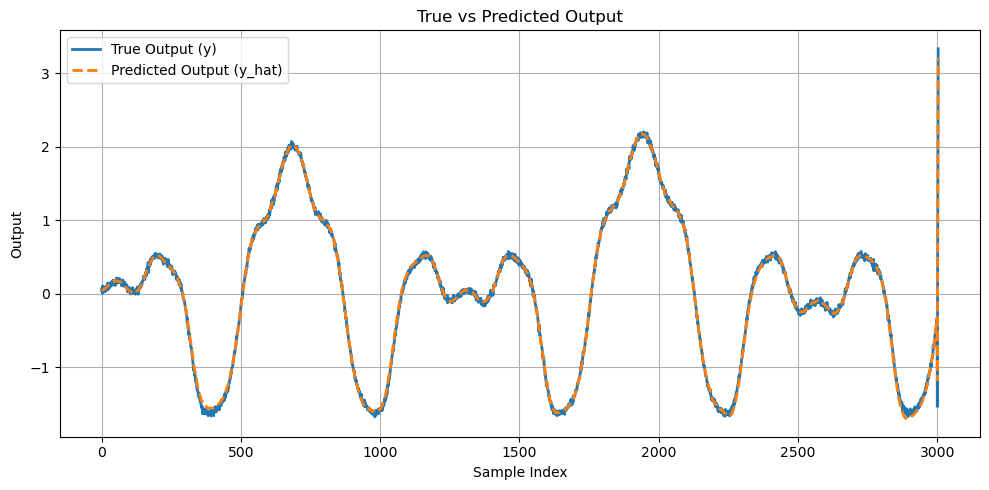

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(y, label='True Output (y)', linewidth=2)
plt.plot(y_hat[iter-1,:], label='Predicted Output (y_hat)', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('True vs Predicted Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Scatter Plot

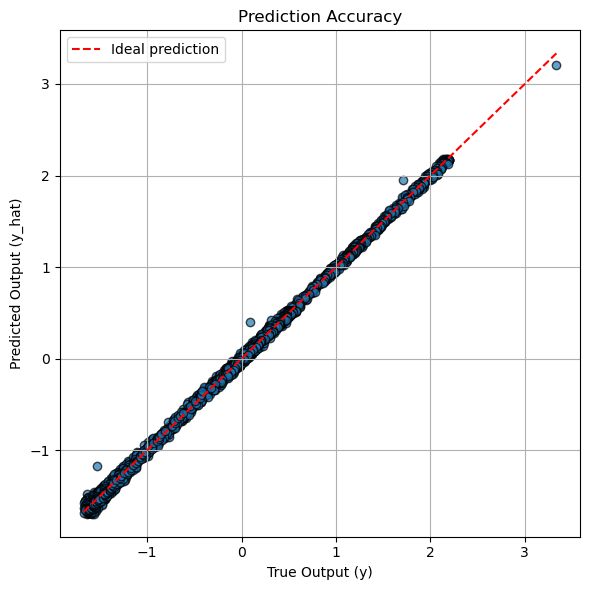

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_hat[iter-1, :], alpha=0.7, edgecolors='k')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal prediction')
plt.xlabel('True Output (y)')
plt.ylabel('Predicted Output (y_hat)')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Numerical Measures

In [35]:
from sklearn.metrics import r2_score, mean_squared_error

print("R² Score:", r2_score(y, y_ghat))
print("MSE:", mean_squared_error(y, y_ghat))

R² Score: 0.9603186539837643
MSE: 0.03984528048704641


## Debugging Section

In [36]:
print((y - y_ghat))

[[0.4699558 ]
 [0.52024249]
 [0.26282363]
 ...
 [3.14425268]
 [3.86931308]
 [4.40776588]]


In [37]:
y_clean = response_train @ wsys        
snr = np.var(y_clean) / (np.var(y) - np.var(y_clean))
print("SNR:", snr)

SNR: 4.6208748562140663e-11


In [38]:
var_signal = np.var(y_clean)
var_noise  = np.var(y - y_clean)
snr = var_signal / var_noise
print("var_signal:", var_signal)
print("var_noise: ", var_noise)
print("SNR:", snr)
print("R2_max (theoretical):", snr / (1+snr))

var_signal: 4.65855932919454e-11
var_noise:  1.008155268122078
SNR: 4.6208748557870285e-11
R2_max (theoretical): 4.6208748555735035e-11


## Performance Evaluation Section Checking

Final iteration performance:
R² Score: 0.06143702472855228
MSE: 0.7359174224533491


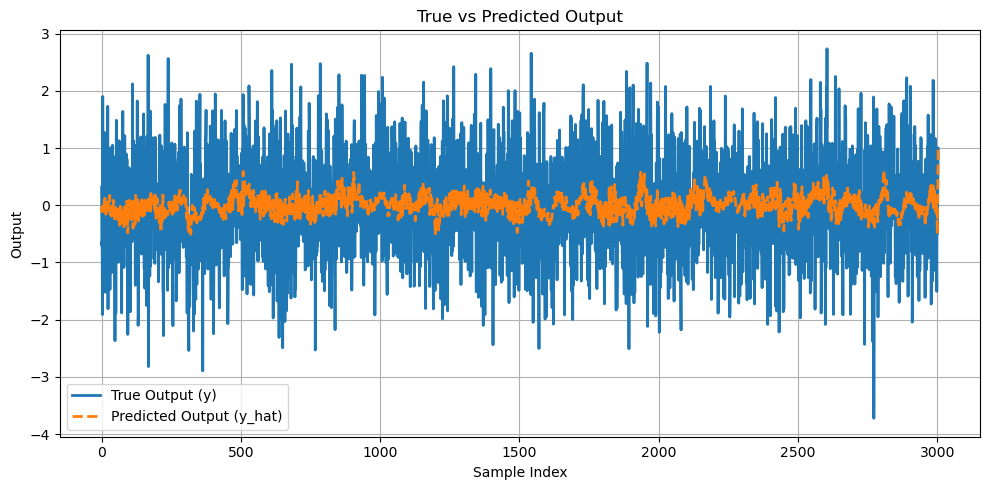

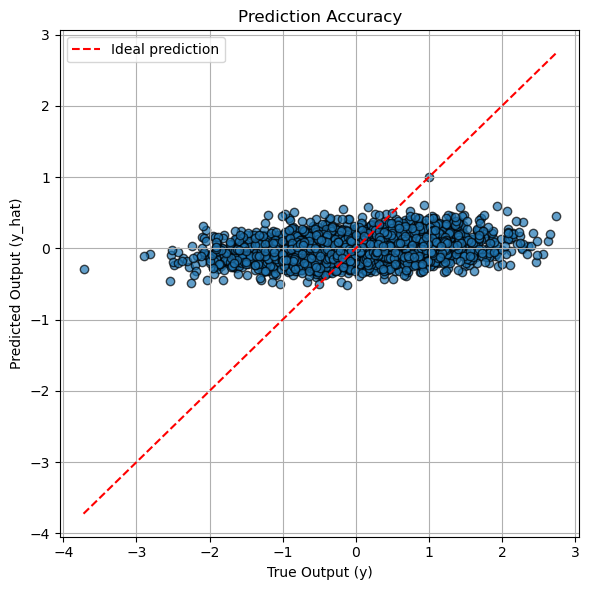

In [34]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

def predict(hpams, y, jitter=1e-6):
    """
    Predict output y_hat using given hyperparameters and ground-truth y.
    Adds jitter for numerical stability.
    """
    # Compute K and E
    k, e = compute_ke(hpams)

    # Hat matrix with jitter for stability
    n = k.shape[0]
    h = k @ np.linalg.inv(k + e + jitter * np.eye(n))

    # Predicted output
    y_hat = h @ y
    return y_hat

# Evaluate over iterations (if needed)
y_hat_matrix = np.zeros((iter, y.shape[0]))

for i in range(iter):
    # Extract hyperparameters for iteration i
    x = x_matrix[i, :]
    hpams = {
        "alphaL": x[0], "alphaNL": x[1], "rhoL": x[2], "lengthNL": x[3],
        "rhoNL": x[4], "rhoT": x[5], "alphaT": x[6], "sigma2": x[7], "d": x[8]
    }

    # Prediction
    y_hat_matrix[i, :] = predict(hpams, y).flatten()

# Compute metrics for last iteration (ground-truth evaluation)
y_hat_final = y_hat_matrix[-1, :]
print("Final iteration performance:")
print("R² Score:", r2_score(y, y_hat_final))
print("MSE:", mean_squared_error(y, y_hat_final))

# Plot predicted vs true output
plt.figure(figsize=(10, 5))
plt.plot(y, label='True Output (y)', linewidth=2)
plt.plot(y_hat_final, label='Predicted Output (y_hat)', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('True vs Predicted Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot for prediction accuracy
plt.figure(figsize=(6, 6))
plt.scatter(y, y_hat_final, alpha=0.7, edgecolors='k')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal prediction')
plt.xlabel('True Output (y)')
plt.ylabel('Predicted Output (y_hat)')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Computing the model weights and the model estimate on the training set 

In [16]:

z = tf.linalg.triangular_solve(cholA, y_train.reshape(9000,1), lower=True)
w = tf.linalg.triangular_solve(cholA.T, z.numpy(), lower=False).numpy()


yhat = Kx @ w   # Estimated y on the training set


In [17]:
covX = cut.getCov(Kx, Kx, cholA)

covXdiag = np.diag(covX) # variance of yhat 

# Plot the outputs and the estimated outputs on the training set, along with 2std confidence interval 

In [ ]:

plt.figure()
#plt.plot(yhat1)
plt.plot(yhat)
plt.plot(y_train, alpha=0.3)
#plt.plot(yhat- 2*covXdiag, 'k--', alpha=0.4)
#plt.plot(yhat + 2*covXdiag, 'k--', alpha=0.4)

plt.show() 

KeyboardInterrupt: 

# Compute steady state of the estimated model 

In [ ]:
ss_rep, sscov  = gpmodel.getKsteadyState(alist, X_train)

ss_est = ss_rep @ w

In [ ]:
sscov = cut.getCov(sscov, ss_rep, cholA)

ssvar = np.diag(sscov)

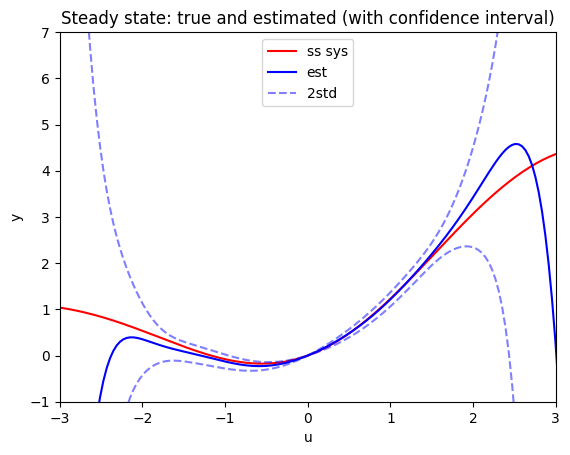

In [ ]:
plt.figure()
plt.title("Steady state: true and estimated (with confidence interval)")

plt.plot(alist, ss_sys, 'r', label="ss sys")
plt.plot(alist, ss_est, 'b', label="est")

plt.plot(alist, ss_est.reshape(200,)+2*ssvar**0.5, 'b--', alpha=0.5, label="2std ")

plt.plot(alist, ss_est.reshape(200,)-2*ssvar**0.5, 'b--', alpha=0.5)

plt.ylabel("y")
plt.xlabel("u")
plt.xlim((-3,3))
plt.ylim((-1, 7))
plt.legend() 
plt.show() 